   ##                         Coursera Capstone Project
###           Topic: Suggesting the best location for setting up an African Restaurant in Calgary

#### Submitted by Taiwo Awe  to coursera as the Capstone Project for IBM Professional Certificate in Data Science

##### The aim of this project is to find the best possible location to set up an African Restaurant in the city of Calgary, Alberta in Canada


First we import the necessary libraries 

In [1]:
import requests #library to handle request
from bs4 import BeautifulSoup
import pandas as pd  # library to process data as dataframes
import numpy as np # library to handle data in a vectorized manner 
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values  
import folium      # map rendering library
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans   # import k-means from clustering stage

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

A list containing the postal codes of Calgary's neighborhoods along with their latitude and longitude coordinates is scraped from a web page of wikipedia using BeautifulSoup

In [2]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T')
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
table = soup.find('table', attrs={'class':'wikitable sortable'})


The html file is passed into DataFrame

In [4]:
df = pd.read_html(str(table))[0]
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


#### Cleaning and Processing the data

In [5]:
df = df[df.Borough != 'Not assigned']  # Dropping the rows where Borough is 'Not assigned'
df = df[df.Latitude != 'Not assigned']
df = df[df.Longitude != 'Not assigned']
df = df[df.Neighborhood != 'Not assigned']
df = df.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)  # Combining the neighborhoods with same Postal Code
df.reset_index(inplace=True)   


# Replacing the neighborhoods which are 'Not assigned' with names of Borough
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned',df['Borough'], df['Neighborhood'])


In [6]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [7]:
df.shape

(97, 5)

In [10]:
df['Latitude'] = pd.to_numeric(df['Latitude'])  # the latitude value is passed into numeric

In [11]:
df['Longitude'] = pd.to_numeric(df['Longitude'])   # the longitude value is passed into numeric

####   Exploring and Clustering the neighborhoods of Toronto

In [12]:
# Get the latitude and longitude coordinates of Calgary
address = "Calgary, Alberta"

geolocator = Nominatim(user_agent="calgary_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary city are 51.0534234, -114.0625892.


Here, we visualize the Calgary's using the folium libary 

In [13]:
# create map of Calgary using latitude and longitude coordinates
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Borough'], 
        df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  

map_calgary


#####  Let's get all the borough in the DataFrame that contains Calgary

In [14]:
df_calgary = df[df['Borough'].str.contains("Calgary")].reset_index(drop=True)
df_calgary.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100


######  Defining the Foursquare API credentials and version

In [15]:
CLIENT_ID = 'K33SGF45U0LCTPWW2P2DTBSMZPWVSZU4YIS5KHC4FQISDKH4' # your Foursquare ID
CLIENT_SECRET = 'SVEKAXAOHPB1EOM3AP32F1TLL3AEDZLN0TJRW2BET51ELN4L' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K33SGF45U0LCTPWW2P2DTBSMZPWVSZU4YIS5KHC4FQISDKH4
CLIENT_SECRET:SVEKAXAOHPB1EOM3AP32F1TLL3AEDZLN0TJRW2BET51ELN4L


Let's explore the first neighborhood in the DataFrame 'df_calgary'

In [16]:
neighborhood_name = df_calgary.loc[0, 'Neighborhood']
print('The first neighborhood is ', neighborhood_name)

The first neighborhood is  Penbrooke Meadows, Marlborough


Get the neighborhood's latitude and longitude values.

In [17]:
neighborhood_latitude = df_calgary.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_calgary.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Penbrooke Meadows, Marlborough are 51.04968, -113.96432.


#### Now, let's get the top 100 venues that are in Penbrooke Meadows and Marlborough within a radius of 1500 meters.

In [24]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

Defining a function that exctract category of the venues

In [25]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Convert the json file into a DataFrame

In [26]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

C:\Users\schor\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Bob Bahan Aquatic & Fitness Centre,Gym / Fitness Center,51.041609,-113.964319
1,Pho Dau Bo,Vietnamese Restaurant,51.037592,-113.963598
2,Olive Garden,Italian Restaurant,51.052937,-113.982449
3,Red Lobster,Seafood Restaurant,51.054367,-113.982448
4,TD Canada Trust,Bank,51.052399,-113.970643
5,The Old Spaghetti Factory,Italian Restaurant,51.055774,-113.981094
6,Shoppers Drug Mart,Pharmacy,51.052750,-113.977420
7,7-Eleven,Convenience Store,51.045519,-113.957341
8,7-Eleven,Convenience Store,51.051550,-113.980266
9,Dairy Queen,Ice Cream Shop,51.037465,-113.968082


And how many venues were returned by Foursquare?

In [27]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

32 venues were returned by Foursquare.


#### Let's now create a function to repeat the same process to all the neighborhoods in Calgary

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
calgary_venues = getNearbyVenues(names=df_calgary['Neighborhood'],
                                   latitudes=df_calgary['Latitude'],
                                   longitudes=df_calgary['Longitude']
                                  )

#### Let's check the size of the resulting dataframe

In [30]:
print(calgary_venues.shape)
calgary_venues.head()

(1670, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Bob Bahan Aquatic & Fitness Centre,51.041609,-113.964319,Gym / Fitness Center
1,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Pho Dau Bo,51.037592,-113.963598,Vietnamese Restaurant
2,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Olive Garden,51.052937,-113.982449,Italian Restaurant
3,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Red Lobster,51.054367,-113.982448,Seafood Restaurant
4,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,TD Canada Trust,51.052399,-113.970643,Bank


Let's check how many venues were returned for each neighborhood

In [31]:
calgary_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",35,35,35,35,35,35
"Brentwood, Collingwood, Nose Hill",23,23,23,23,23,23
"Bridgeland, Greenview, Zoo, YYC",100,100,100,100,100,100
"City Centre, Calgary Tower",100,100,100,100,100,100
"Connaught, West Victoria Park",100,100,100,100,100,100
"Cranston, Auburn Bay, Mahogany",17,17,17,17,17,17
"Dalhousie, Edgemont, Hamptons, Hidden Valley",8,8,8,8,8,8
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",11,11,11,11,11,11
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",17,17,17,17,17,17


#### Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(calgary_venues['Venue Category'].unique())))

There are 187 uniques categories.


#### Now we are ready to analyze each neighborhood

In [33]:
# one hot encoding
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

calgary_onehot.head()



,Yoga Studio,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
calgary_grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()
calgary_grouped.head()

,Neighborhood,Yoga Studio,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Braeside, Cedarbrae, Woodbine",0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.0,0.00,0.0,0.00,0.028571,0.0,0.0
1,"Brentwood, Collingwood, Nose Hill",0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.00,0.043478,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0
2,"Bridgeland, Greenview, Zoo, YYC",0.00,0.00,0.0,0.0,0.0,0.03,0.0,0.0,0.01,...,0.01,0.000000,0.00,0.0,0.05,0.0,0.00,0.000000,0.0,0.0
3,"City Centre, Calgary Tower",0.01,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.01,...,0.00,0.000000,0.02,0.0,0.00,0.0,0.01,0.000000,0.0,0.0
4,"Connaught, West Victoria Park",0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.00,0.000000,0.02,0.0,0.01,0.0,0.00,0.000000,0.0,0.0


In [35]:
calgary_grouped.shape

(34, 187)

####  Check the 10 most common venues in each neighborhood.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_grouped['Neighborhood']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Coffee Shop,Gas Station,Convenience Store,Pub,Liquor Store,Sandwich Place,Fast Food Restaurant,Shopping Mall,Smoothie Shop,Lake
1,"Brentwood, Collingwood, Nose Hill",Pub,Convenience Store,Furniture / Home Store,Liquor Store,Gym,Park,Smoothie Shop,Burger Joint,Bubble Tea Shop,Coffee Shop
2,"Bridgeland, Greenview, Zoo, YYC",Chinese Restaurant,Coffee Shop,Vietnamese Restaurant,Pub,Italian Restaurant,Café,Sandwich Place,Park,Convenience Store,Asian Restaurant
3,"City Centre, Calgary Tower",Restaurant,Hotel,Pub,Café,Steakhouse,Coffee Shop,Pizza Place,Bakery,Diner,Brewery
4,"Connaught, West Victoria Park",Restaurant,Coffee Shop,Pizza Place,Pub,Italian Restaurant,Bakery,Brewery,Bar,Cocktail Bar,Steakhouse


####  Now, we ready to cluster the neighborhoods

We will be using the KMeans clustering for the clutering, but first, we need to write the code to get the optimal value of K using the elbow method

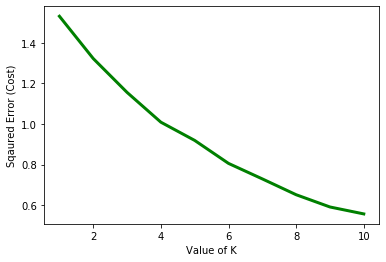

In [41]:
import matplotlib.pyplot as plt

calgary_grouped_clustering = calgary_grouped.drop('Neighborhood', 1)
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(calgary_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k

Analysing the graph suggest the value of 4 as the best fit for k

In [42]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

calgary_merged = df_calgary

# merge calgary_grouped with calgary_data to add latitude/longitude for each neighborhood
calgary_merged = calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

 # check the last columns!

In [44]:
calgary_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320,1,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Ice Cream Shop,Pharmacy,Italian Restaurant,Restaurant,Convenience Store,Gym / Fitness Center,Pub
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,0,Convenience Store,Asian Restaurant,Gas Station,Chinese Restaurant,Gym / Fitness Center,Trail,General Entertainment,Filipino Restaurant,Flea Market,Gastropub
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,1,Grocery Store,Vietnamese Restaurant,Fast Food Restaurant,Convenience Store,Bar,Sandwich Place,Pizza Place,Liquor Store,Gym / Fitness Center,Golf Course
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,1,Coffee Shop,Pizza Place,Convenience Store,Grocery Store,Clothing Store,Restaurant,Sporting Goods Shop,Fast Food Restaurant,Park,Cosmetics Shop
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100,1,Pizza Place,Coffee Shop,Pharmacy,Supermarket,Convenience Store,Spa,Comic Shop,Grocery Store,Skating Rink,Restaurant


Now let's visualize the resulting clusters 

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        calgary_merged['Latitude'], 
        calgary_merged['Longitude'], 
        calgary_merged['Neighborhood'], 
        calgary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Now, we'll examine each of the clusters

Cluster '0'

In [50]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 0, calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,Convenience Store,Asian Restaurant,Gas Station,Chinese Restaurant,Gym / Fitness Center,Trail,General Entertainment,Filipino Restaurant,Flea Market,Gastropub
9,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",0,Pizza Place,Convenience Store,Sandwich Place,Italian Restaurant,Other Great Outdoors,Sporting Goods Shop,Thrift / Vintage Store,Gym / Fitness Center,Women's Store,Frozen Yogurt Shop
14,"Thorncliffe, Tuxedo Park",0,Convenience Store,Breakfast Spot,Bakery,Park,Tea Room,Gastropub,Mediterranean Restaurant,Restaurant,Gourmet Shop,Brewery


Cluster '1'

In [51]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 1, calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Penbrooke Meadows, Marlborough",1,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Ice Cream Shop,Pharmacy,Italian Restaurant,Restaurant,Convenience Store,Gym / Fitness Center,Pub
2,"Forest Lawn, Dover, Erin Woods",1,Grocery Store,Vietnamese Restaurant,Fast Food Restaurant,Convenience Store,Bar,Sandwich Place,Pizza Place,Liquor Store,Gym / Fitness Center,Golf Course
3,"Montgomery, Bowness, Silver Springs, Greenwood",1,Coffee Shop,Pizza Place,Convenience Store,Grocery Store,Clothing Store,Restaurant,Sporting Goods Shop,Fast Food Restaurant,Park,Cosmetics Shop
4,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",1,Pizza Place,Coffee Shop,Pharmacy,Supermarket,Convenience Store,Spa,Comic Shop,Grocery Store,Skating Rink,Restaurant
5,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",1,Coffee Shop,Pub,Pizza Place,Restaurant,Vietnamese Restaurant,Sandwich Place,Mexican Restaurant,Grocery Store,Moroccan Restaurant,Diner
6,"Bridgeland, Greenview, Zoo, YYC",1,Chinese Restaurant,Coffee Shop,Vietnamese Restaurant,Pub,Italian Restaurant,Café,Sandwich Place,Park,Convenience Store,Asian Restaurant
7,"Lakeview, Glendale, Killarney, Glamorgan",1,Pizza Place,Coffee Shop,Korean Restaurant,Supermarket,Convenience Store,Bar,Gas Station,Snack Place,Smoothie Shop,Bowling Alley
8,"Inglewood, Burnsland, Chinatown, East Victoria...",1,Restaurant,Hotel,Pub,Coffee Shop,Performing Arts Venue,Bakery,Cocktail Bar,Italian Restaurant,New American Restaurant,Steakhouse
10,"Highfield, Burns Industrial",1,Coffee Shop,American Restaurant,Grocery Store,Pharmacy,Sushi Restaurant,Burger Joint,Restaurant,Italian Restaurant,Vietnamese Restaurant,Asian Restaurant
11,"Discovery Ridge, Signal Hill, West Springs, Ch...",1,Gas Station,Dog Run,Kids Store,Grocery Store,Health & Beauty Service,Convenience Store,Restaurant,Bank,Bar,Vietnamese Restaurant


Cluster  '2'

In [52]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 2, calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Northeast Calgary,2,Hotel,Coffee Shop,American Restaurant,Gas Station,Sporting Goods Shop,Gym / Fitness Center,Women's Store,Football Stadium,Gastropub,Furniture / Home Store


Cluster '3'

In [53]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 3, calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Northwest Calgary,3,Golf Course,Gas Station,Park,Liquor Store,Flea Market,Sandwich Place,Grocery Store,Women's Store,Football Stadium,Furniture / Home Store
